
# Lesson 13 — Debugging ML Models & Error Analysis (CS229-style)

This lesson is **less about new algorithms** and more about a *repeatable workflow* for improving models.

You’ll implement:
- A simple classifier (logistic regression, NumPy only)
- **Train/val/test split**
- **Confusion matrix**, accuracy, precision, recall, F1
- **Threshold tuning** (cost-sensitive decisions)
- **PR curves** for skewed classes
- **Error analysis**: find *where* the model fails and what to do next

> CS229 theme: *don’t guess improvements — measure them.*



## 0) Setup


In [1]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)



## 1) Create an imbalanced dataset (skewed classes)

This mimics real-life cases like fraud detection, rare failures, medical screening, etc.
Accuracy alone becomes misleading.


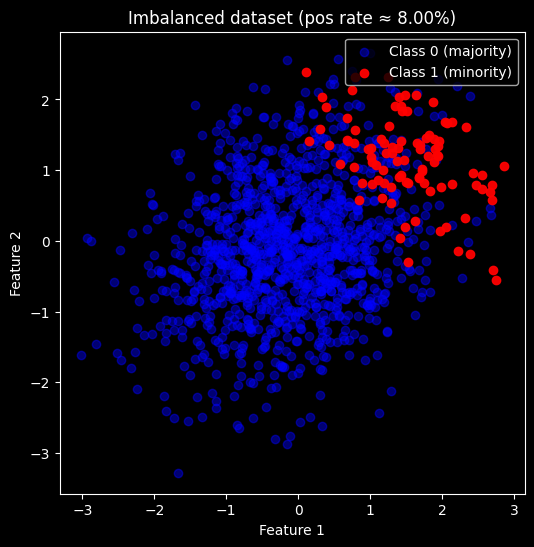

In [2]:

# Imbalanced 2D dataset (class 1 is rare)
n = 1200
pos_frac = 0.08
n1 = int(n * pos_frac)
n0 = n - n1

# Majority (class 0): broad blob
mu0 = np.array([0.0, 0.0])
S0  = np.array([[1.6, 0.3],
                [0.3, 1.1]])

# Minority (class 1): shifted blob
mu1 = np.array([2.2, 1.4])
S1  = np.array([[0.7, -0.2],
                [-0.2, 0.5]])

X0 = np.random.multivariate_normal(mu0, S0, n0)
X1 = np.random.multivariate_normal(mu1, S1, n1)

X = np.vstack([X0, X1])
y = np.array([0]*n0 + [1]*n1)

# Shuffle
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

# Standardize (important for GD stability)
X = (X - X.mean(axis=0)) / X.std(axis=0)

plt.figure(figsize=(6,6))
plt.scatter(X[y==0,0], X[y==0,1], color="blue", alpha=0.45, label="Class 0 (majority)")
plt.scatter(X[y==1,0], X[y==1,1], color="red",  alpha=0.95, label="Class 1 (minority)")
plt.title(f"Imbalanced dataset (pos rate ≈ {y.mean():.2%})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(loc="upper right")
plt.show()



## 2) Train / Validation / Test split

We’ll pick hyperparameters on **validation**, then report final performance on **test**.


In [3]:

def train_val_test_split(X, y, train_frac=0.70, val_frac=0.15, seed=0):
    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(X))
    X, y = X[idx], y[idx]
    n = len(X)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, seed=1)

print("Sizes:", len(X_train), len(X_val), len(X_test))
print("Train pos rate:", y_train.mean())
print("Val pos rate:", y_val.mean())
print("Test pos rate:", y_test.mean())


Sizes: 840 180 180
Train pos rate: 0.08214285714285714
Val pos rate: 0.1
Test pos rate: 0.05



## 3) Baseline model: Logistic Regression (NumPy only)

We’ll optimize cross-entropy with gradient descent.


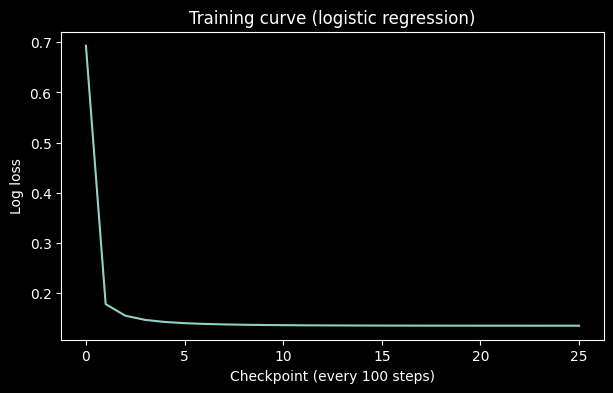

In [4]:

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def add_intercept(X):
    return np.c_[np.ones((X.shape[0], 1)), X]

def log_loss(p, y):
    eps = 1e-9
    p = np.clip(p, eps, 1-eps)
    return -np.mean(y*np.log(p) + (1-y)*np.log(1-p))

def train_logreg(X, y, lr=0.1, steps=2000):
    Xb = add_intercept(X)
    y = y.reshape(-1,1)
    theta = np.zeros((Xb.shape[1], 1))
    m = len(X)

    hist = {"loss":[]}
    for t in range(steps):
        p = sigmoid(Xb @ theta)              # (m,1)
        grad = (Xb.T @ (p - y)) / m          # (d+1,1)
        theta -= lr * grad
        if t % 100 == 0 or t == steps-1:
            hist["loss"].append(log_loss(p, y))
    return theta, hist

theta, hist = train_logreg(X_train, y_train, lr=0.25, steps=2500)

plt.figure(figsize=(7,4))
plt.plot(hist["loss"])
plt.xlabel("Checkpoint (every 100 steps)")
plt.ylabel("Log loss")
plt.title("Training curve (logistic regression)")
plt.show()



## 4) Metrics that matter for skewed classes

Accuracy can look great even if you miss most positives.

We’ll implement:
- Confusion matrix
- Precision, Recall, F1
- Compute metrics at different thresholds


In [5]:

def predict_proba(X, theta):
    Xb = add_intercept(X)
    return sigmoid(Xb @ theta).reshape(-1)

def predict_label(p, thresh=0.5):
    return (p >= thresh).astype(int)

def confusion_counts(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    tp = np.sum((y_true==1) & (y_pred==1))
    tn = np.sum((y_true==0) & (y_pred==0))
    fp = np.sum((y_true==0) & (y_pred==1))
    fn = np.sum((y_true==1) & (y_pred==0))
    return tp, tn, fp, fn

def precision_recall_f1(y_true, y_pred):
    tp, tn, fp, fn = confusion_counts(y_true, y_pred)
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    f1   = 2*prec*rec / (prec + rec + 1e-9)
    acc  = (tp + tn) / (tp + tn + fp + fn + 1e-9)
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "tp":tp, "tn":tn, "fp":fp, "fn":fn}


In [6]:

p_val = predict_proba(X_val, theta)

for t in [0.5, 0.3, 0.2, 0.1]:
    yhat = predict_label(p_val, thresh=t)
    m = precision_recall_f1(y_val, yhat)
    print(f"threshold={t:0.2f} | acc={m['acc']:.3f} prec={m['prec']:.3f} rec={m['rec']:.3f} f1={m['f1']:.3f} | fp={m['fp']} fn={m['fn']}")


threshold=0.50 | acc=0.922 prec=0.750 rec=0.333 f1=0.462 | fp=2 fn=12
threshold=0.30 | acc=0.906 prec=0.533 rec=0.444 f1=0.485 | fp=7 fn=10
threshold=0.20 | acc=0.917 prec=0.571 rec=0.667 f1=0.615 | fp=9 fn=6
threshold=0.10 | acc=0.900 prec=0.500 rec=1.000 f1=0.667 | fp=18 fn=0



## 5) Precision–Recall curve (better than ROC for heavy class imbalance)

We sweep the threshold and plot precision vs recall.


In [7]:

def pr_curve(y_true, p_score, n_thresh=200):
    thresholds = np.linspace(0, 1, n_thresh)
    precisions, recalls = [], []
    for t in thresholds:
        y_pred = (p_score >= t).astype(int)
        m = precision_recall_f1(y_true, y_pred)
        precisions.append(m["prec"])
        recalls.append(m["rec"])
    return np.array(recalls), np.array(precisions), thresholds

rec, prec, thresholds = pr_curve(y_val, p_val)

plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (validation)")
plt.ylim(0, 1.02)
plt.xlim(0, 1.02)
plt.show()

# Find best F1 threshold on validation
best = {"f1":-1}
for t in thresholds:
    yhat = (p_val >= t).astype(int)
    m = precision_recall_f1(y_val, yhat)
    if m["f1"] > best["f1"]:
        best = {"t":t, **m}

best


{'t': np.float64(0.17587939698492464),
 'acc': np.float64(0.9277777777726235),
 'prec': np.float64(0.5925925925706447),
 'rec': np.float64(0.8888888888395061),
 'f1': np.float64(0.7111111105995059),
 'tp': np.int64(16),
 'tn': np.int64(151),
 'fp': np.int64(11),
 'fn': np.int64(2)}


## 6) Cost-sensitive thresholding (business decision)

Often you have explicit costs:
- False negative (miss a positive) cost = **C_FN**
- False positive (flag a negative) cost = **C_FP**

Choose the threshold that minimizes expected cost on validation.


In [8]:

def best_threshold_by_cost(y_true, p_score, C_FN=10.0, C_FP=1.0, n_thresh=400):
    thresholds = np.linspace(0, 1, n_thresh)
    best = {"cost":np.inf}
    for t in thresholds:
        y_pred = (p_score >= t).astype(int)
        tp, tn, fp, fn = confusion_counts(y_true, y_pred)
        cost = C_FN*fn + C_FP*fp
        if cost < best["cost"]:
            best = {"t":t, "cost":cost, "tp":tp, "tn":tn, "fp":fp, "fn":fn}
    return best

# Example: missing a positive is 15x worse than a false alert
best_cost = best_threshold_by_cost(y_val, p_val, C_FN=15.0, C_FP=1.0)
best_cost


{'t': np.float64(0.08771929824561403),
 'cost': np.float64(18.0),
 'tp': np.int64(18),
 'tn': np.int64(144),
 'fp': np.int64(18),
 'fn': np.int64(0)}

In [9]:

# Compare thresholds: default vs best-F1 vs cost-optimal
t_default = 0.5
t_f1 = best["t"]
t_cost = best_cost["t"]

def eval_threshold(name, t):
    yhat = (p_val >= t).astype(int)
    m = precision_recall_f1(y_val, yhat)
    print(f"{name:>10} t={t:.3f} | acc={m['acc']:.3f} prec={m['prec']:.3f} rec={m['rec']:.3f} f1={m['f1']:.3f} | fp={m['fp']} fn={m['fn']}")

eval_threshold("default", t_default)
eval_threshold("bestF1", t_f1)
eval_threshold("costOpt", t_cost)


   default t=0.500 | acc=0.922 prec=0.750 rec=0.333 f1=0.462 | fp=2 fn=12
    bestF1 t=0.176 | acc=0.928 prec=0.593 rec=0.889 f1=0.711 | fp=11 fn=2
   costOpt t=0.088 | acc=0.900 prec=0.500 rec=1.000 f1=0.667 | fp=18 fn=0



## 7) Visualization: decision regions + mistakes (CS229 style)

- Background = predicted probability \(p(\text{Class 1}|x)\)
- White contour = 0.5 boundary (or chosen threshold)
- Points are true labels
- Mark mistakes with X/O


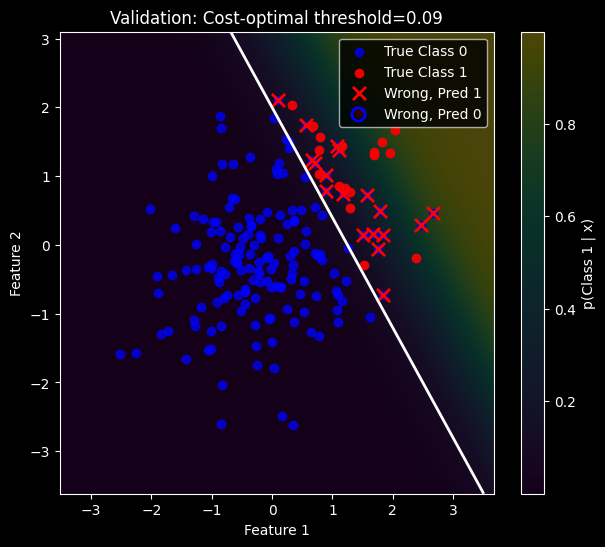

In [10]:

def plot_prob_surface_with_mistakes(X, y, proba_fn, thresh=0.5, title="Decision surface", show_mistakes=True):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 350),
        np.linspace(y_min, y_max, 350)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    P = proba_fn(grid).reshape(xx.shape)

    plt.figure(figsize=(7,6))
    im = plt.imshow(P, origin="lower", extent=(x_min,x_max,y_min,y_max), aspect="auto", alpha=0.30)
    cbar = plt.colorbar(im)
    cbar.set_label("p(Class 1 | x)")

    plt.contour(xx, yy, P, levels=[thresh], colors="white", linewidths=2)

    # True labels as solid points
    plt.scatter(X[y==0,0], X[y==0,1], color="blue", alpha=0.75, label="True Class 0")
    plt.scatter(X[y==1,0], X[y==1,1], color="red",  alpha=0.90, label="True Class 1")

    if show_mistakes:
        p = proba_fn(X)
        pred = (p >= thresh).astype(int)
        wrong = pred != y
        plt.scatter(X[wrong & (pred==1),0], X[wrong & (pred==1),1],
                    marker="x", s=90, linewidths=2, color="red", label="Wrong, Pred 1")
        plt.scatter(X[wrong & (pred==0),0], X[wrong & (pred==0),1],
                    marker="o", s=90, facecolors="none", edgecolors="blue", linewidths=2,
                    label="Wrong, Pred 0")

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc="upper right")
    plt.show()

proba_fn = lambda Xq: predict_proba(Xq, theta)
plot_prob_surface_with_mistakes(X_val, y_val, proba_fn, thresh=t_default, title="Validation: Logistic Regression (threshold=0.5)")
plot_prob_surface_with_mistakes(X_val, y_val, proba_fn, thresh=t_cost, title=f"Validation: Cost-optimal threshold={t_cost:.2f}")



## 8) Error analysis: find patterns in mistakes

A simple CS229-style approach:
1. Collect mistakes (FP / FN)
2. Slice them by simple criteria (e.g., Feature 1 bins)
3. Look for concentrated failure regions

This tells you what to do next:
- add features?
- change model class?
- gather more data in a slice?
- fix label noise?


In [11]:

def bin_slices(x, bins):
    # returns bin index 0..len(bins)-2
    return np.digitize(x, bins) - 1

def error_slices(X, y_true, p_score, thresh, feature_index=0, bins=None):
    if bins is None:
        bins = np.quantile(X[:,feature_index], [0,0.2,0.4,0.6,0.8,1.0])
    pred = (p_score >= thresh).astype(int)
    tp, tn, fp, fn = confusion_counts(y_true, pred)
    s = bin_slices(X[:,feature_index], bins)
    out = []
    for bi in range(len(bins)-1):
        mask = (s == bi)
        if mask.sum() == 0:
            continue
        yt = y_true[mask]
        yp = pred[mask]
        m = precision_recall_f1(yt, yp)
        out.append((bi, mask.sum(), m["prec"], m["rec"], m["f1"], m["fp"], m["fn"]))
    return bins, out

p_val = predict_proba(X_val, theta)
bins, slices = error_slices(X_val, y_val, p_val, thresh=t_cost, feature_index=0)

print("Feature 1 bin edges:", bins)
print("bin | count | prec | rec | f1 | fp | fn")
for bi, cnt, pr, rc, f1, fp, fn in slices:
    print(f"{bi:>3} | {cnt:>5} | {pr:>.3f} | {rc:>.3f} | {f1:>.3f} | {fp:>3} | {fn:>3}")


Feature 1 bin edges: [-2.51883008 -0.84416349 -0.28237442  0.26436636  0.83928724  2.67294837]
bin | count | prec | rec | f1 | fp | fn
  0 |    36 | 0.000 | 0.000 | 0.000 |   0 |   0
  1 |    36 | 0.000 | 0.000 | 0.000 |   0 |   0
  2 |    36 | 0.000 | 0.000 | 0.000 |   1 |   0
  3 |    36 | 0.625 | 1.000 | 0.769 |   3 |   0
  4 |    35 | 0.500 | 1.000 | 0.667 |  13 |   0



## 9) Final report on TEST (after selecting threshold on validation)

This is what you would show in a writeup: *one* threshold choice, then test metrics.


In [12]:

p_test = predict_proba(X_test, theta)
yhat_test = (p_test >= t_cost).astype(int)
m_test = precision_recall_f1(y_test, yhat_test)
m_test


{'acc': np.float64(0.9277777777726235),
 'prec': np.float64(0.40909090907231405),
 'rec': np.float64(0.9999999998888889),
 'f1': np.float64(0.5806451608407909),
 'tp': np.int64(9),
 'tn': np.int64(158),
 'fp': np.int64(13),
 'fn': np.int64(0)}


## Key Takeaways (Lesson 13)

### What to measure (especially for skewed classes)
- **Accuracy is often misleading.** If positives are rare, predicting all zeros can look “great”.
- Use a **confusion matrix** and derive:
  - **Precision**: of flagged positives, how many are truly positive?
  - **Recall**: of true positives, how many did we catch?
  - **F1**: harmonic mean of precision and recall (useful when you need a single number)

### Thresholds are part of the model
- Logistic regression outputs **probabilities** (or scores). The **threshold** turns scores into actions.
- Different thresholds produce different tradeoffs:
  - Lower threshold ⇒ higher recall, more false positives
  - Higher threshold ⇒ higher precision, more false negatives
- Choose thresholds on **validation**, not on test.

### When to use PR curves (and why)
- For **imbalanced datasets**, PR curves are more informative than ROC curves.
- PR tells you: *“If I demand 80% recall, what precision do I pay?”*

### Cost-sensitive decision making
- In real problems, false positives and false negatives often have **different costs**.
- You can pick a threshold that minimizes:
  \[
  \text{cost} = C_{FN}\cdot FN + C_{FP}\cdot FP
  \]
- This is how you connect ML to real operations (fraud alerts, safety systems, medical triage).

### Error analysis is the multiplier
Instead of randomly trying “better models,” do this:
1. Inspect **where mistakes cluster** (feature slices, regions in the plot)
2. Identify failure type:
   - Many **FN** in a region ⇒ model is under-sensitive there (features missing, threshold too high)
   - Many **FP** in a region ⇒ model is overconfident there (overlap, noisy labels, poor features)
3. Decide action:
   - Collect more data in that slice
   - Engineer a targeted feature
   - Change model class (linear → non-linear)
   - Fix label noise / inconsistent labeling rules

### Practical debugging checklist (CS229 mindset)
- Did you standardize features (for GD stability)?
- Do train/val/test distributions match (pos rate drift)?
- Is your metric aligned with the objective (precision/recall/cost)?
- Are errors concentrated in an interpretable slice?
- Are you tuning hyperparameters/thresholds on validation only?

If you can do Lesson 13 well, you can improve almost any ML system faster than someone who just “tries bigger models.”
